# Learning categorical and numeric features with Functional API

a series on getting deeper into DNN implementations in keras.

this week I am focusing on building DNN for data that has both categorical and numeric features.

I started with banking_prediction.ipynb. The banking data is stored on S3, and I am reading from S3 directly on the EC2 instance (or local machine for that matter).

Then I found a better tutorial so I am running through it in this notebook.

Read paper: https://arxiv.org/pdf/1604.06737.pdf

Blog post:
https://medium.com/@satnalikamayank12/on-learning-embeddings-for-categorical-data-using-keras-165ff2773fc9

TASK in this notebook:
THis is a regression problem.

the original form of the blogpost and the github code don't work any more. It used deprecated API of Merge Sequential models. Instead, we need to modifiy it to use functional API, concatenating categorical and numeric inputs, we need to specify all the inputs and outputs and finally put it together. This is a nice lesson that shows the complexity of the pipeline of building a deep learning model from data encoding and transformation all the way to the final model training. This is particularly challenging because we using Functional API which needs you to be clear headed on how each input and output and each layer are strung together. 

In [6]:
import pandas as pd 
df = pd.read_csv("train.csv")

In [7]:
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [8]:
df = df.sample(frac=1) 

In [9]:
df['season'].value_counts()

4    2734
3    2733
2    2733
1    2686
Name: season, dtype: int64

In [10]:
df['workingday'].value_counts()

1    7412
0    3474
Name: workingday, dtype: int64

In [11]:
df['holiday'].value_counts()

0    10575
1      311
Name: holiday, dtype: int64

In [12]:
df['weather'].value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

In [13]:
df[:3]

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10292,2012-11-14 06:00:00,4,0,1,1,9.84,11.365,65,12.9980,4,142,146
4930,2011-11-18 12:00:00,4,0,1,1,13.12,16.665,33,0.0000,22,143,165
7554,2012-05-14 03:00:00,2,0,1,2,23.78,27.275,68,22.0028,0,2,2


In [14]:
import datetime

In [15]:
df['date']  = df.datetime.apply(lambda x: x.split()[0])
df['hour'] = df.datetime.apply(lambda x: x.split()[1].split(':')[0])
df['weekday'] = df.date.apply(lambda dateString : datetime.datetime.strptime(dateString, '%Y-%m-%d').weekday())
df['month'] = df.date.apply(lambda dateString : datetime.datetime.strptime(dateString, '%Y-%m-%d').month)
df['month_day'] = df.date.apply(lambda dateString : datetime.datetime.strptime(dateString, '%Y-%m-%d').day)

In [16]:
df = df.drop('datetime',axis=1)
df = df.drop('casual',axis=1)
df = df.drop('registered',axis=1)
df = df.drop('date',axis=1)
preds  = df['count']
df = df.drop('count',axis=1)

In [17]:
preds.describe( )

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

In [18]:
df[:3]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,weekday,month,month_day
10292,4,0,1,1,9.84,11.365,65,12.9980,06,2,11,14
4930,4,0,1,1,13.12,16.665,33,0.0000,12,4,11,18
7554,2,0,1,2,23.78,27.275,68,22.0028,03,0,5,14


In [19]:
categorical_vars = ["hour", "month", "weekday","season","weather","month_day"]

In [20]:
all_cols = df.columns

In [21]:
all_cols

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'hour', 'weekday', 'month', 'month_day'],
      dtype='object')

In [22]:
other_cols = [i for i in all_cols if i not in categorical_vars ]

In [24]:
other_cols

['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed']

In [25]:
import numpy as np 
def preproc(X_train ) : 

    input_list_train = []
    for c in categorical_vars :
        
        jjj = np.asarray(X_train[c].tolist())
        jjj = pd.factorize( jjj )[0]
        input_list_train.append( np.asarray(jjj)  )
        """
        raw_vals = np.unique(X_train[c])
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        input_list_train.append(X_train[c].map(val_map).values)
        """
    #the rest of the columns
    input_list_train.append(X_train[other_cols].values)
    return input_list_train 
df_tr = preproc( df )

In [32]:
len(df_tr)

7

In [41]:
np.array(preds).shape

(10886,)

In [35]:
print(df_tr[0].shape)
print(df_tr[-1].shape)

(10886,)
(10886, 6)


In [48]:
target.shape

(10886,)

# model specification

This section builds the model.

Now we have transformed the data into the df_tr matrix. it looks like this:

In [33]:
df_tr # the numeric features are lumped together in one list element


[array([0, 1, 2, ..., 8, 9, 6]),
 array([0, 0, 1, ..., 4, 4, 1]),
 array([0, 1, 2, ..., 0, 0, 6]),
 array([0, 0, 1, ..., 3, 3, 1]),
 array([0, 0, 1, ..., 0, 0, 1]),
 array([ 0,  1,  0, ..., 11, 11, 16]),
 array([[ 0.    ,  1.    ,  9.84  , 11.365 , 65.    , 12.998 ],
        [ 0.    ,  1.    , 13.12  , 16.665 , 33.    ,  0.    ],
        [ 0.    ,  1.    , 23.78  , 27.275 , 68.    , 22.0028],
        ...,
        [ 0.    ,  1.    , 11.48  , 12.88  , 61.    , 19.9995],
        [ 0.    ,  1.    , 22.14  , 25.76  , 42.    , 23.9994],
        [ 0.    ,  1.    , 22.14  , 25.76  , 68.    , 15.0013]])]

## important point

Note that the following section of model compilation doesn't depend on the actual input data yet. It is purely a placeholder kind of thing. All it needs is the dimensions expect of the input data, for each categorical and numeric feature. In contrast, later in model.fit(), we will need to worry about the actual input data shape matching these expectations specified in the model.compile(). That's why we need to prepare the data and transform them into these expected shapes before the model.fit.

for example, let's take the first categorical attribute, ```df_tr[0]```, this line translate to expected shape of 24 dimensions for each instance, since there are 24 unique values for this variable in this data: 

```    inp_cat_data = keras.layers.Input(shape=(no_of_unique_cat,)) 
```

Therefore, we can pass in 1d data as is ```[2,5,1,6...]``` but we need to make it one hot into the shape of (None,24) so to speak. That section is after the model.compile() and before model.fit().

It may not be intuitive at first but note that the model compile is all about placeholders and no actual data is passed in.

In [84]:
from keras.layers import *
from keras.models import *
import tensorflow as tf
import keras
models = []

inputs = []
#categorical_vars = ["hour", "month", "weekday","season","weather","month_day"]
for categoical_var in categorical_vars :
    #model = Sequential()
    #model.reset_states( )
    no_of_unique_cat  = df[categoical_var].nunique()
    embedding_size = min(np.ceil((no_of_unique_cat)/2), 50 )
    embedding_size = int(embedding_size)
    #model.add(  Embedding( no_of_unique_cat+1, embedding_size, input_length = 1 ) )
    #model.add(Reshape(target_shape=(embedding_size,)))
    #models.append( model )
    inp_cat_data = keras.layers.Input(shape=(no_of_unique_cat,)) 
    inputs.append(inp_cat_data)
    emb = keras.layers.Embedding(input_dim=no_of_unique_cat, output_dim=embedding_size)(inp_cat_data)  #emb size(None, 4, 2)
    flatten = keras.layers.Flatten()(emb) # after flatten => (None, 8)
    models.append(flatten)
    

num_data = df_tr[-1]
inp_num_data = keras.layers.Input(shape=(num_data.shape[1],)) #(None, 3) #doc on input layer: https://keras.io/layers/core/
models.append(inp_num_data)
inputs.append(inp_num_data)
#model_rest = Sequential()
#model_rest.add(Dense(  64 , input_dim = 6 ))
#model_rest.reset_states( )
#models.append(model_rest)
# WHAT WE NEED TO DO IS TO WRITE IT WITH THE FIRST TUTORIAL'S SYNTAX\\
# using functional API to concatenate is the new way of Merge 
# https://stackoverflow.com/questions/46397258/how-to-merge-sequential-models-in-keras-2-0
conc = keras.layers.Concatenate()(models)

#model = keras.Model(inputs=[inp_cat_data, inp_num_data], outputs=out)
dense1 = keras.layers.Dense(512, activation=tf.nn.relu, )(conc) 
dense2 = keras.layers.Dense(64, activation=tf.nn.relu, )(dense1) 

#doc on dense layer: https://keras.io/layers/core/

# Creating output layer - this is regression so just one unit with no activation output
out = keras.layers.Dense(1)(dense2)

# functional API: only string together the model now with input and output
# inputs is a list 
# https://keras.io/models/model/ 
# In the case of multi-input or multi-output models, you can use lists as well:
# model = Model(inputs=[a1, a2], outputs=[b1, b2, b3])

model = keras.Model(inputs=inputs, outputs=out)

# for continuous targets
#model.compile(optimizer=tf.train.AdamOptimizer(0.01),
              #loss=keras.losses.mean_squared_error,
             # metrics=[keras.metrics.mean_squared_error])
#opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

#model.compile(loss='categorical_crossentropy',
              #optimizer=opt,
              #metrics=['accuracy'])





#full_model = Sequential()
#full_model.add(Merge(models, mode='concat'))

#full_model.add(Dense(512))
#full_model.add(Activation('sigmoid'))
#full_model.add(Dropout(0.2))

#full_model.add(Dense(32))
#full_model.add(Activation('sigmoid'))
#full_model.add(Dropout(0.2))

#full_model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='Adam',metrics=['mse','mape'])  

In [85]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           (None, 24)           0                                            
__________________________________________________________________________________________________
input_44 (InputLayer)           (None, 12)           0                                            
__________________________________________________________________________________________________
input_45 (InputLayer)           (None, 7)            0                                            
__________________________________________________________________________________________________
input_46 (InputLayer)           (None, 4)            0                                            
____________________________________________________________________________________________

## we need to one hot encode the input categorical data

due to:     inp_cat_data = keras.layers.Input(shape=(no_of_unique_cat,)) 

we can't pass in one dimensional input data for categorical.

In [70]:
# one hot encode categorical variables
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

def encode_onehot(cat_input):
    cat_input=np.expand_dims(cat_input, axis=1)
    # creating instance of one-hot-encoder
    enc = OneHotEncoder(handle_unknown='ignore')
    # passing bridge-types-cat column (label encoded values of bridge_types)
    enc_df = enc.fit_transform(cat_input).toarray()
    return enc_df

In [81]:
cat_input = df_tr[0]
res = encode_onehot(cat_input)
res.shape

(10886, 24)

In [66]:
res.shape

(10886, 24)

In [78]:
new_df_tr = []
for d in df_tr[:-1]:
    new_df_tr.append(encode_onehot(d))
new_df_tr.append(df_tr[-1])
assert(len(new_df_tr)==len(df_tr))

In [82]:
len(new_df_tr)

7

## finally we train the model passing in the actual data

In [21]:
#full_model = Sequential()
#full_model.reset_states( )
#full_model.add(Merge(models, mode='concat'))
#full_model.add(Dense( 256 , activation='sigmoid'))
#full_model.add(Dense(32, activation='sigmoid'))
#full_model.add(Dropout(0.2))
#full_model.add(Dense(1 ))

#full_model.compile(loss='mean_squared_error', optimizer='Adam' ,metrics=['mse','mape'])

/home/ms/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  This is separate from the ipykernel package so we can avoid doing imports until


In [86]:
history  =  model.fit( new_df_tr  , preds  , epochs =  50 , batch_size = 16, verbose= 1  )

Epoch 1/50
10886/10886 [==============================] - 3s 303us/step - loss: 21007.9078 - mse: 21007.9082 - mape: 343.2191
Epoch 2/50
10886/10886 [==============================] - 3s 266us/step - loss: 11248.3748 - mse: 11248.3721 - mape: 97.6956
Epoch 3/50
10886/10886 [==============================] - 3s 278us/step - loss: 10131.7102 - mse: 10131.7119 - mape: 87.4686
Epoch 4/50
10886/10886 [==============================] - 3s 268us/step - loss: 7714.8988 - mse: 7714.8999 - mape: 70.7681
Epoch 5/50
10886/10886 [==============================] - 3s 266us/step - loss: 6035.0729 - mse: 6035.0752 - mape: 61.6759
Epoch 6/50
10886/10886 [==============================] - 3s 271us/step - loss: 5467.8788 - mse: 5467.8779 - mape: 57.9146
Epoch 7/50
10886/10886 [==============================] - 3s 278us/step - loss: 5088.1161 - mse: 5088.1177 - mape: 53.4698
Epoch 8/50
10886/10886 [==============================] - 3s 272us/step - loss: 4926.8430 - mse: 4926.8428 - mape: 51.7281
Epoch 9/5

In [87]:
history.params

{'batch_size': 16,
 'do_validation': False,
 'epochs': 50,
 'metrics': ['loss', 'mse', 'mape'],
 'samples': 10886,
 'steps': None,
 'verbose': 1}

In [89]:
loss = history.history['loss']
mse = history.history['mse']
mape = history.history['mape']#['mean_absolute_percentage_error']

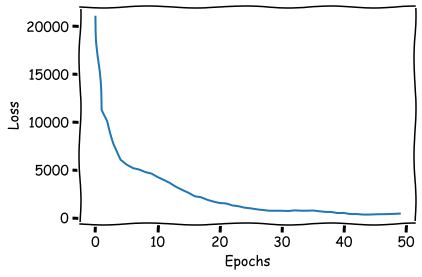

In [90]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.xkcd()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot( loss  )


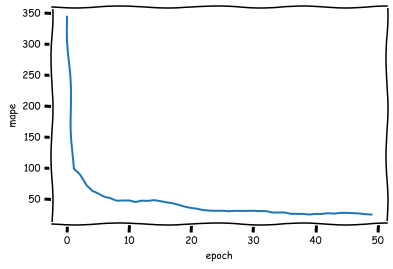

In [91]:
plt.xlabel("epoch")
plt.ylabel("mape")
plt.plot( mape )

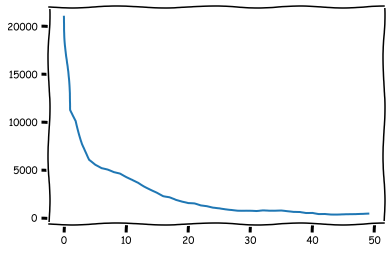

In [92]:
plt.plot( mse)